# STACKING ANALYSIS

### sped up stacking analysis using numba.jit decorator with nopython=true

In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools as itrt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from itertools import repeat
from functools import partial
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()



#Importing UPtime data
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()


#Importing Aeff data
filenames = ["IC40_effectiveArea.csv", "IC59_effectiveArea.csv","IC79_effectiveArea.csv", "IC86_I_effectiveArea.csv", "IC86_II_effectiveArea.csv"]
file = filenames[0]
f = open(os.path.join(irf_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
eadata = []
for file in filenames:
    content = []
    f = open(os.path.join(irf_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column, dtype=float)
    #temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    #temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    eadata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read
IC40_effectiveArea.csv read
IC59_effectiveArea.csv read
IC79_effectiveArea.csv read
IC86_I_effectiveArea.csv read
IC86_II_effectiveArea.csv read


In [3]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
print(np.sum(icwidths))

1134450


In [4]:
icdata

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.379113,3.31,0.48,203.024,16.760,218.374,106.712
1,54562.386622,5.17,0.62,75.024,-13.371,349.100,76.646
2,54562.387892,3.92,0.56,97.501,11.290,327.060,101.291
3,54562.392677,5.57,1.13,305.857,-33.932,120.413,56.090
4,54562.404776,5.80,1.11,143.516,-38.279,287.171,51.684
...,...,...,...,...,...,...,...
1134445,58307.961110,5.14,0.20,221.246,-59.959,141.239,29.956
1134446,58307.962666,2.94,1.23,191.547,4.415,171.627,94.312
1134447,58307.963556,2.88,0.30,308.127,42.543,55.437,132.606
1134448,58307.963972,2.98,0.21,332.199,44.720,31.489,134.811


In [5]:
ictimes = [float(i) for i in icdata['MJD[days]']]
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]
#icparts.pop(-1)
#icparts

In [6]:
upt_icparts = icparts[:5]
upt_icparts.append(icparts[-1])
len(upt_icparts) - 1 == len(eadata)

True

In [7]:
log_e = np.round(np.arange(2, 10.2, 0.2), 2)
dec_nu = list(set(eadata[0]['Dec_nu_min[deg]'].values).union(set(eadata[0]['Dec_nu_max[deg]'].values)))
dec_nu.sort()
dec_nu = np.array(dec_nu)

In [8]:
nu_e = 5
e_ind = 0
for i in range(len(log_e) - 1):
    if nu_e >= log_e[i] and nu_e < log_e[i+1]:
        e_ind = i
print([e_ind, i])

[15, 39]


In [9]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


In [10]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
iceng = np.array([float(i) for i in icdata['log10(E/GeV)']])
global p, lg, lnu
p = len(msra)
lg = len(icra) // p + 1
lnu = len(icra)

In [11]:
[min(icdec), max(icdec)]

[-89.957, 89.977]

In [12]:
icra[[0, 6, 8] ]

array([203.024, 147.017, 236.214])

## STACKING ANALYSIS

$\gamma$ = 2.0

$e_{nu}$ = $1e11^{ \gamma}$


weights = \[$A_{eff}$[i] * $T_{uptime}$[i] * $e_{nu}$ *0.2  for i in range(len(A_{eff}))\]

![SNOWFALL](test.png)

In [13]:
e_nu = ((10**(log_e[:-1])+ 10**(log_e[1:]))/2)*1e9
#de_nu = 1e9**0.2

In [14]:
len(e_nu)

40

In [15]:
upstop_ttt = np.asfarray([uptdata[i]['MJD_stop[days]'].values[-1] for i in range(len(uptdata))])
upstart_ttt = np.asfarray([uptdata[i]['MJD_start[days]'].values[0] for i in range(len(uptdata))])
earea = np.array([eadata[i]['A_Eff[cm^2]'].values for i in range(len(eadata))]) * 1e-4

In [16]:
log_e

array([ 2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,
        4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,
        6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,
        8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ])

In [17]:
de_nu = 1e9*(10**log_e[1:] - 10**log_e[:-1])

In [18]:
upstop_ttt

array([54971.15026394, 55347.28439144, 55694.41019675, 56062.41831018,
       56414.41614583, 56783.57893518, 57160.04101851, 57528.85952546,
       57891.16406249, 58309.08234953])

In [19]:
de_nu

array([5.84893192e+10, 9.26993239e+10, 1.46918527e+11, 2.32850174e+11,
       3.69042656e+11, 5.84893192e+11, 9.26993239e+11, 1.46918527e+12,
       2.32850174e+12, 3.69042656e+12, 5.84893192e+12, 9.26993239e+12,
       1.46918527e+13, 2.32850174e+13, 3.69042656e+13, 5.84893192e+13,
       9.26993239e+13, 1.46918527e+14, 2.32850174e+14, 3.69042656e+14,
       5.84893192e+14, 9.26993239e+14, 1.46918527e+15, 2.32850174e+15,
       3.69042656e+15, 5.84893192e+15, 9.26993239e+15, 1.46918527e+16,
       2.32850174e+16, 3.69042656e+16, 5.84893192e+16, 9.26993239e+16,
       1.46918527e+17, 2.32850174e+17, 3.69042656e+17, 5.84893192e+17,
       9.26993239e+17, 1.46918527e+18, 2.32850174e+18, 3.69042656e+18])

In [20]:
@jit(nopython=True)
def psr_wt_quick(nusample_wall, psrno, gamma = 1):

    '''
    Parameters
    ----------
    nusample_wall : float
        The index of catalogue of the given neutrino
    psrno : int
        The index of the pulsar in the ATNF catalogue
    gamma : float, optional
        (default) 1
        The spectral index of the power law
    Returns the weight of psrno^th pulsar for a given neutrino sample {nusample_wall}
    '''
    
    #nu_e = icdata['log10(E/GeV)'].values[nu]
    psr_decl = icdec[psrno]
    #upt = upt_icparts[nusample_wall]
    t_upt = upstop_ttt[nusample_wall] - upstart_ttt[nusample_wall]
    t_upt*=86400
    d_ind = 0
    for i in range(len(dec_nu) - 1):
        if dec_nu[i] <= psr_decl and dec_nu[i+1] >= psr_decl:
            d_ind = i
            break
    ea_temp = earea[nusample_wall][d_ind*40:(d_ind+1)*40]
    #earea = np.array(ea_temp['A_Eff[cm^2]'].values) * 1e-4
    weight_kj = t_upt * np.sum(np.multiply(np.multiply(ea_temp, np.power(e_nu, gamma)), de_nu))
    #sleep(1e-8)
    return weight_kj                           
            

all_weights[i][j] = weight of pulsar i in j^th partition of uptime data (upt_part)

In [21]:
psr_wt_quick(0, 0, 1)

1.0648611917333613e+46

In [22]:
from tqdm import tqdm
all_weights = []
gamma = 1
for i in tqdm(range(len(upt_icparts)-1)):
    print(upt_icparts[i])
    all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
all_weights = np.asfarray(all_weights)
sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
sum_weights

100%|██████████| 5/5 [00:00<00:00, 330.06it/s]

0
36900
143911
237044
373288


array([1.32872417e+52, 1.57592493e+50, 1.59530636e+50, 2.07699567e+50,
       1.97632107e+50])

In [23]:
type(all_weights[0])

numpy.ndarray

In [24]:
vec_uptparts = np.asarray(upt_icparts, dtype=np.int64)

icdata = []
mspdata = []
uptdata = []
eadata = []

In [25]:
@jit(nopython=True)
def hvovec(lon1=0.0, lat1=0.0, lon2=0.0, lat2=0.0, rad=False):

    '''
    Parameters
    ----------
    lon1 : float
        Longitude of first point.
    lat1 : float
        Latitude of first point.


    lon2 : float
        Longitude of second point.
    lat2 : float
        Latitude of second point.

    rad : Boolean, optional
        (default) False -> Angle is returned in Degrees
        True -> Angle is returned in radians
    

    Returns
    -------
    float
        Returns the haversine angle between two vectors given their latitude and longitude
    

    Warning
    -------
        This function assumes the input to be in degrees and of equal length\n
        or one of the input pairs to be a single value and the other pair to be an array
    '''

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    if rad == True:
        return np.arccos(a)
    else:
        return np.abs(np.rad2deg(np.arccos(a)))


In [26]:
@jit(nopython=True)
def S_ij(nu): 

    '''
    Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2#, icra[nuind], icdec[nuind], rad=True) ** 2
    sg = np.deg2rad(icang[nu]) ** 2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))

@jit(nopython=True)
def S_i(nu, all_weights, sum_weights, wall):

    '''
        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample

        Returns
        -------
        Returns the signal PDF for the {nu}th neutrino with all pulsars 
        i.e S_i = wieghted-sum_j S_ij
    '''



    sij = S_ij(nu)
    
    #sleep(1e-8)
    return np.sum(np.multiply(sij, all_weights[wall] / sum_weights[wall]))
    #return np.dot(sij, all_weights[wall] ) / sum_weights[wall]



![SNOWFALL](bg.png)

### For this project, Cone is $5{\degree}$

In [27]:
vec_uptparts

array([      0,   36900,  143911,  237044,  373288, 1134450])

In [28]:
@jit(nopython=True)
def Bi_stacked(nu, cone):

    '''
    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    #count = 0
    #count = np.count_nonzero(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    #print(count)
    count = 0
    for i in range(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    #print(count)
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    #sleep(1e-8)
    return count/(binwidth * lnu)
    

@jit(nopython=True)
def Pr(x, Ns, S, B):

    '''
    Parameters
    ----------
    x : int
        Assumed no.of associated events

    Ns : int
        No.of neutrinos used for analysis

    S : float
        Signal PDF
    B : float
        Background PDF
    
    Returns
    -------
    float 
        Returns the probability of the selected set of neutrinos being associated\n
        with a given pulsar with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


@jit(nopython=True)
def wall_nu(nu):
    
        '''
        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        
    
        Returns
        -------
        int
            Returns the index of the wall in which the {nu}th neutrino lies
        '''
        wall = 0
        for i in range(len(vec_uptparts)-1):
            if vec_uptparts[i] <= nu and vec_uptparts[i+1] > nu:
                wall = i
                break        
        return wall

Find 

In [29]:
Bi_stacked(0, 5)

0.10819734211672001

#B_i independent of weights
all_B_i = np.asarray([Bi_stacked(i, 5) for i in tqdm(range(len(icra)))])

In [30]:
pool = mul.Pool(8, maxtasksperchild=100)
op_star = pool.starmap_async(Bi_stacked, zip(range(lnu), 5*np.ones(lnu)) )
all_Bi = op_star.get()
pool.close()
pool = []
op_star =[]
all_Bi = np.asarray(all_Bi)

In [31]:
S_i(2, all_weights, sum_weights, 1)

0.1448996049028885

This method takes ~30 minutes for 100000 neutrinos

$\implies$ 1134450 neutrinos take ~6.5 to 7hrs!!

UNACCEPTABLE!!!

NEED FASTER METHOD

USING @jit(nopython=True) SPEEDS UP A LOT!!!

NEW EXECUTION TIME IS: 10mins

In [32]:
pool = []
op_async = []

mul.set_start_method('spawn', force=True)

In [33]:
mul.get_all_start_methods()
mul.get_start_method()

'fork'

In [34]:
upt_icparts = np.asarray(upt_icparts)

In [35]:
upt_icparts

array([      0,   36900,  143911,  237044,  373288, 1134450])

In [36]:
@jit(nopython=True)
def weights_gamma(gamma):
    all_weights= []
    for i in range(len(upt_icparts)-1):
    #print(upt_icparts[i])
        all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
    return np.asfarray(all_weights)

    
all_weights = weights_gamma(2)
gamma_list = np.asarray([1, 2, 2.5, 3])
sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
cut = 5
cone = 5
sum_weights_gamma = []
all_weights_gamma = np.asfarray([weights_gamma(gamma) for gamma in gamma_list])
for i in all_weights_gamma:
    sum_weights_gamma.append([np.sum(j) for j in i])
sum_weights_gamma = np.asfarray(sum_weights_gamma)
all_weights_mgamma = np.asfarray([weights_gamma(-gamma) for gamma in gamma_list])
#nuind, ang = angfinder(psrno, cut)


In [37]:
weights_gamma(1)

array([[1.06486119e+46, 3.99128321e+48, 2.25622540e+46, ...,
        1.67108381e+40, 7.98729866e+47, 2.54128811e+49],
       [3.86709142e+44, 8.46303481e+46, 3.86889354e+45, ...,
        1.29193052e+42, 2.69580858e+46, 2.03491544e+47],
       [4.45925952e+44, 8.60103362e+46, 2.99649286e+45, ...,
        1.98169238e+41, 2.21058647e+46, 1.82242898e+47],
       [4.88093071e+44, 1.08296022e+47, 3.89860257e+45, ...,
        3.09242353e+42, 2.94198359e+46, 2.27293997e+47],
       [5.58036122e+44, 1.19373772e+47, 5.21074494e+45, ...,
        4.67929077e+41, 3.32959945e+46, 1.89244047e+47]])

In [38]:
sum_weights == sum_weights_gamma[1]

array([ True,  True,  True,  True,  True])

In [39]:
np.shape(all_weights_gamma)

(4, 5, 3341)

In [43]:
def weights(gamma):
    all_weights= []
    for i in range(len(upt_icparts)-1):
    #print(upt_icparts[i])
        all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
    return np.asfarray(all_weights)
all_weights = weights(1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
cut = 5
cone = 5

In [44]:

#nuind, ang = angfinder(psrno, cut)

@jit(nopython=True, cache=True)
def sigbag_nu(nu):
    '''
        Returns the signal and background PDF for the {nu}th neutrino
    '''

    #sleep(1e-8)

    #if nu % 100000 == 0:
        #print(nu)
        #os.system('clear')
    wall = wall_nu(nu)
    #Ns = vec_uptparts[wall_nu(nu) + 1] - vec_uptparts[wall_nu(nu)]
    return [S_i(nu, all_weights, sum_weights, wall), all_Bi[nu]]#,Ns]

In [45]:
all_sig_bag = []

In [46]:
#gamma = 1
all_weights = weights(1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []

100%|██████████| 1134450/1134450 [00:18<00:00, 62138.30it/s] 


In [47]:
tmp = np.asfarray(tmp)

In [48]:
tmp

array([[4.09851985e-012, 1.08197342e-001],
       [2.59074357e-005, 6.36115708e-002],
       [1.09514444e-001, 1.20943005e-001],
       ...,
       [1.79205173e-003, 7.47313300e-002],
       [4.58041973e-068, 7.36453528e-002],
       [5.15099865e-152, 1.37209853e-001]])

In [49]:
S_all = tmp[:,0]
B_all = tmp[:,1]
#Ns_all = tmp2[:,2]

In [50]:
Ns = lnu

In [51]:
@jit(nopython=True)
def TS_st(x, S, B, Ns):

    '''
    Returns
    ----------
        Returns the Test Stastic value at
        $n_s$ = {x} for its parameters S, B, Ns
    '''
    if x >=0:
        return np.sum(np.asfarray(2*np.log(Pr(x,  Ns, S, B)/B)))
    else:
        return -1

def ns_for_TSmax_st(S, B, Ns):
    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st(x, S, B, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]
    #print(soln.success)
    return ns

In [52]:
ns_for_TSmax_st(S_all[0], B_all[0], lnu)

0.0

def nstest(nu):
    return ns_for_TSmax_st(S_all[nu], B_all[nu], lnu)

#'''
test = []
for i in tqdm(range(lnu)):
    test.append(nstest(i))
    #if i % 100000 == 0:
    #    print(i)
#'''
#pool = []
#op_async = []
#pool = mul.Pool(12, maxtasksperchild=100)
#op_async = pool.map_async(nstest, range(lnu))
#test = op_async.get()

op_async = pool.map_async(nstest, range(lnu))

np.argmax(test)

In [53]:
all_sig_bag = []

In [54]:
#gamma = 1
all_weights = weights(-1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

#gamma = 2
all_weights = weights(-2)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

#gamma = -2.5
all_weights = weights(-2.5)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)



#gamma = -3
all_weights = weights(-3)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

 16%|█▌        | 177260/1134450 [00:00<00:02, 325503.52it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 22%|██▏       | 248164/1134450 [00:00<00:02, 308059.20it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 25%|██▌       | 283616/1134450 [00:00<00:02, 308286.31it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=Tr

In [55]:
all_sig_bag[3][760000]

array([0.00587095, 0.13706247])

def plotnu(nu):
    tns=[TS_st(i, S_all[nu], B_all[nu], lnu) for i in range(0, 1000)]
    plt.plot(range(0, 1000), tns)
    plt.show()

plotnu(np.argmax(test))

In [56]:
all_sig = []

for i in all_sig_bag:
    all_sig.append(i[:,0])
all_sig = np.asfarray(all_sig)
all_sig_bag[3][4567][0] == all_sig[3][4567]

True

In [57]:
Ns = lnu#np.count_nonzero(nuind+1)
from numba import njit, prange
@njit(parallel=True, fastmath=True)
def Ts_arr(x, S_all, B_all, Ns):
    #Ts_arr = lambda x:
    sum = 0.0
    for i in range(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum


In [58]:
Ts_arr(165, all_sig[3], B_all, Ns)

/home/darkwake/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../tmp/ipykernel_16146/1171155522.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


-1.4074029802030583

In [59]:
all_tns_gamma = []
for i in tqdm(prange(4)):
    tmpp = []
    for j in prange(1000):
        tmpp.append(Ts_arr(j, all_sig[i], B_all, Ns))
    all_tns_gamma.append(tmpp)

100%|██████████| 4/4 [02:39<00:00, 39.95s/it]


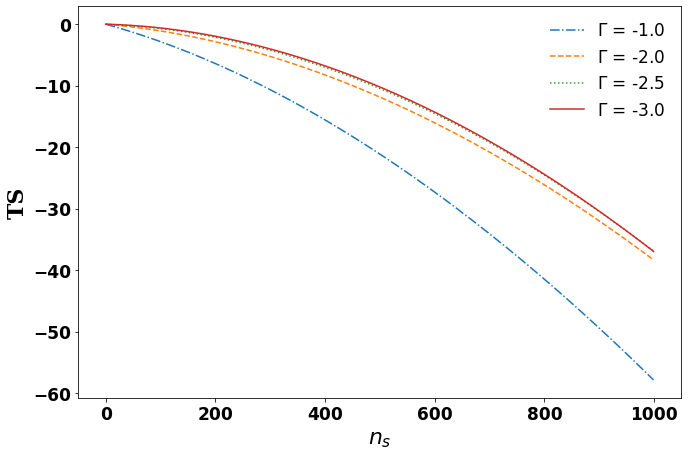

In [60]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')
lst = ['-.', '--', ':', '-']
for i in range(4):
    plt.plot(range(1000), all_tns_gamma[i],label=r'$\Gamma$ = -'+str(gamma_list[i]), ls=lst[i])
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.xlabel('$n_s$', fontdict=font)
plt.ylabel('TS', fontdict=font)
plt.show()

In [64]:
all_sig_bag_positive_gamma = []

#gamma = 1
all_weights = weights(1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag_positive_gamma.append(tmp)

#gamma = 2
all_weights = weights(2)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag_positive_gamma.append(tmp)

#gamma = 2.5
all_weights = weights(2.5)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag_positive_gamma.append(tmp)



#gamma = 3
all_weights = weights(3)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag_positive_gamma.append(tmp)

 17%|█▋        | 193227/1134450 [00:00<00:02, 383946.91it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 24%|██▍       | 275370/1134450 [00:00<00:02, 375116.08it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 28%|██▊       | 313423/1134450 [00:00<00:02, 360594.54it/s]/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
/tmp/ipykernel_16146/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=Tr

In [65]:
all_sig = []

for i in all_sig_bag:
    all_sig.append(i[:,0])
all_sig = np.asfarray(all_sig)
all_sig_bag[3][4567][0] == all_sig[3][4567]

True

In [66]:
all_tns_gamma = []
for i in tqdm(prange(4)):
    tmpp = []
    for j in prange(1000):
        tmpp.append(Ts_arr(j, all_sig[i], B_all, Ns))
    all_tns_gamma.append(tmpp)

100%|██████████| 4/4 [02:40<00:00, 40.08s/it]


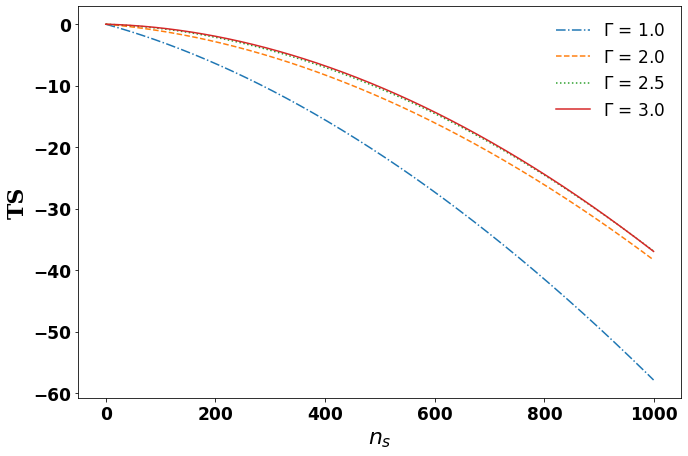

In [67]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')
lst = ['-.', '--', ':', '-']
for i in range(4):
    plt.plot(range(1000), all_tns_gamma[i],label=r'$\Gamma$ = '+str(gamma_list[i]), ls=lst[i])
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.xlabel('$n_s$', fontdict=font)
plt.ylabel('TS', fontdict=font)
plt.show()

In [ ]:
def ns_for_TSmax(S, B, Ns):

    '''
    Parameters
    ----------
    
    S : float
        Signal PDF
    B : float
        Background PDF
    
    Ns : int
        No.of neutrinos used for analysis
    
    Returns
    -------
    Returns the value of $n_s$ for which
    the TS is maximum for the given Signal,
    Background parameters of a pulsar
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(x, S, B, Ns)
    soln = minimize(nll, 6 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns

print("%lf",np.round(tsmax_for_nu(.2, .3, 1), 5))

In [ ]:
0.00001<1e-3

mul.freeze_support()
def drive_stack_nsmaxonly(gamma):
    all_weights = weights(gamma)
    sum_weights = [np.sum(i) for i in all_weights]
    sum_weights = np.asfarray(sum_weights)
    cut = 5
    cone = 5
    
    pool = mul.Pool(8, maxtasksperchild=100)
    op_async = pool.map_async(sigbag_nu, range(len(icdec)))
    tmp = op_async.get()
    pool.close()
    pool = []
    op_async = []
    tmp = np.asfarray(tmp)
    #all_ns = []
    #for i in tqdm(range(len(icdec))):
    #    all_ns.append(tsmax_for_nu(S_all, B_all, i))
    return tmp

g1 = drive_stack_nsmaxonly(2)

In [ ]:
def _tsmax_for_nu(i):
    nll = lambda x: -TS_st(x, S_all[i], B_all[i], lnu)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 7)[0]    
    ret = TS_st(ns, S_all[i], B_all[i], lnu)
    if np.abs(ret) <=1e-4:
        return 0
    return ret
    
all_ns_gamma = []
Ns = lnu
for i in range(4):
    pool = mul.Pool(8, maxtasksperchild=100)
    op_async = pool.map_async(_tsmax_for_nu, range(len(icdec)))
    #all_ns = op_async.get()
    all_ns_gamma.append(op_async.get())
    pool.close()
    pool = []
    op_async = []

all_ns = all_ns_for_gamma(g1)

all_tsmax_gamma = []
for gamma in [-1, -2, -2.5, 3]:
    g1 = drive_stack_nsmaxonly(gamma)
    tmp = np.asfarray(g1)
    S_all = tmp[:,0]
    B_all = tmp[:,1]
    Ns = lnu
    pool = mul.Pool(8, maxtasksperchild=100)
    op_async = pool.map_async(_tsmax_for_nu, range(len(icdec)))
    all_ns = op_async.get()
    pool.close()
    pool = []
    op_async = []
    all_tsmax_gamma.append([TS_st(all_ns[i], S_all[i], B_all[i], lnu) for i in tqdm(range(len(icdec)))])
    

def all_ns_for_gamma(tmp):
    S_all = tmp[:,0]
    B_all = tmp[:,1]
    
    def _nu(i):
        nll = lambda x: -TS_st(x, S_all[i], B_all[i], lnu)
        soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
        ns = np.round(soln.x, 7)[0]
    
        ret = TS_st(ns, S_all[i], B_all[i], lnu)
        if np.abs(ret) <=1e-4:
            return 0
        return ret
    
    
    Ns = lnu
    pool = mul.Pool(8, maxtasksperchild=100)
    op_async = pool.map_async(_nu, range(len(icdec)))
    all_ns = op_async.get()
    pool.close()
    pool = []
    op_async = []
    return all_ns
    

tmp

all_ns_for_gamma(tmp)

all_tsmax = [TS_st(all_ns[i], S_all[i], B_all[i], lnu) for i in tqdm(range(len(icdec)))]

plt.figure(figsize=(32,18))
plt.rcParams.update({'font.size': 48})
plt.xlabel("$E_{\u03BD}$")
plt.ylabel("$TS_{max}$")
#plt.xscale('log')
plt.scatter(np.multiply(10**9, iceng)**2, all_tsmax)
plt.show()

all_tsmax_gamma[1]

In [ ]:
len(all_ns_gamma[0])

In [ ]:
#gaussian = lambda x, mean, var:  amp*norm.pdf(x, mean, var)
def gaussian(x,mean,sd):
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
gx = np.linspace(0, wsts[-1], 100)

In [ ]:
print(all_ns_gamma[0][0], all_ns_gamma[1][0])

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')

amp  = lnu/3.0#np.sum(binnedsts)/ne01
for all_tsmax in all_ns_gamma:
    binnedsts, wsts = np.histogram(np.sqrt(all_tsmax), 10)    
    #binnedsts = binnedsts/amp
    print(binnedsts)
    yerr = np.sqrt(binnedsts)
    b2 = binnedsts[(binnedsts>10)]
    yerr2 = yerr[(binnedsts>10)]
    x=0.5*(wsts[1:]+ wsts[:-1])
    x2 = x[(binnedsts>10)]
    xerr=x[0]-wsts[0]
    loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
    gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
    gx = np.linspace(0, wsts[-1], 100)
    plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='o', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
    legend =plt.legend(prop={'size':17}, framealpha=0)
    legend.get_frame().set_facecolor('none')


plt.show()
    

binnedsts, wsts = np.histogram(np.sqrt(all_tsmax), 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>10)]
yerr2 = yerr[(binnedsts>10)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>10)]
xerr=x[0]-wsts[0]

yerr

wsts

In [ ]:
gparam

kde = lambda x, binnedsts, var: max(b2)*gaussian_kde.pdf()
kparam, kerr = curve_fit(kde, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 100000, method='dogbox')
kx = np.linspace(0, max(wsts), 100)

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')
#plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=17, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
#plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/stacking analysis/gamma1.png")
plt.show()

In [ ]:
all_ns_for_gamma(tmp)

In [ ]:
def drive_stack(gamma):
    all_weights = weights_o(gamma)
    this.all_weights = all_weights
    sum_weights = [np.sum(i) for i in all_weights]
    sum_weights = np.asfarray(sum_weights)
    this.sum_weights = sum_weights
    cut = 5
    cone = 5
    th
    pool = mul.Pool(8, maxtasksperchild=100)
    op_async = pool.map_async(sigbag_nu, range(len(icdec)))
    tmp = op_async.get()
    pool.close()
    pool = []
    op_async = []
    tmp = np.asfarray(tmp)
    S_all = tmp[:,0]
    B_all = tmp[:,1]
    Ns = lnu
    nll = lambda x: -Ts_arr(x, S_all, B_all, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]
    allts=[Ts_arr(i,S_all, B_all, Ns) for i in range(0, 1000)]
    return [ns, allts]  

In [ ]:
all_ts_gamma = [drive_stack(gamma) for gamma in [-1, -2, -2.5, -3]]

In [ ]:
all_ts_gamma[1][1]

In [ ]:
log_e

In [ ]:
all_ts_gamma[0][0]

In [ ]:
type(all_ts_gamma[4][1])

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
gamma = [1, 2, 2.5, 3]
plt.plot(range(0, 1000), all_ts_gamma[0][1], ls = ':', label = f'$\Gamma$ = {gamma[0]}')
plt.plot(range(0, 1000), all_ts_gamma[1][1], ls = '-',label = f'$\Gamma$ = {gamma[1]}')
plt.plot(range(0, 1000), all_ts_gamma[2][1], ls='--',label = f'$\Gamma$ = {gamma[2]}')
plt.plot(range(0, 1000), all_ts_gamma[3][1], ls='-.',label = f'$\Gamma$ = {gamma[3]}')
#for i in range(len(all_ts_gamma)):
    #plt.plot(range(0, 1000), all_ts_gamma[i][1], label = f'{gamma[i]}')
    #print(i)
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.xlabel('$n_s$', fontdict=font)
plt.ylabel('TS', fontdict=font)
plt.savefig("outputs/stackedTS.jpg")
#plt.legend()
plt.show()

In [ ]:
binnedsts, wsts = np.histogram(maxts, 10)

ne01 = 3
amp  = p/3.0#np.sum(binnedsts)/ne01
#binnedsts = binnedsts/amp
yerr = np.sqrt(binnedsts)
b2 = binnedsts[(binnedsts>10)]
yerr2 = yerr[(binnedsts>10)]
x=0.5*(wsts[1:]+ wsts[:-1])
x2 = x[(binnedsts>10)]
xerr=x[0]-wsts[0]

In [ ]:
yerr

In [ ]:
wsts

In [ ]:
#gaussian = lambda x, mean, var:  amp*norm.pdf(x, mean, var)
def gaussian(x,mean,sd):
#    mean=0.114
    A=p/3.0
    return A*np.exp(-(x - mean) ** 2.0 / sd ** 2.0)
loggaussian = lambda x, mean, var:  np.log(gaussian(x, mean, var))
gparam, gerr = curve_fit(gaussian, x2, b2,  p0=[0.1, 1.0],sigma=yerr2, absolute_sigma=True, maxfev = 10000, method='dogbox')
gx = np.linspace(0, wsts[-1], 100)

In [ ]:
gparam

In [ ]:
max(maxts)

In [ ]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize=17, fontweight='bold')

plt.errorbar(x, binnedsts, xerr=xerr,yerr=yerr,  aa = True, barsabove = True, fmt='ob',ecolor='blue', elinewidth=1.35, label='$\sqrt{TS_{max}}$')
plt.plot(gx,gaussian(gx, gparam[0], gparam[1]),'--', alpha=0.6, label=f'Gaussian Fit', color='darkred', lw=2.2)

plt.xlabel("$\mathbf{\sqrt{TS_{max}}}$", fontweight='bold', fontdict=font)
plt.ylabel("No.of Events", fontweight='bold', fontdict=font)
#plt.grid(True, which='major')
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.savefig("outputs/sqrt(TSmax)stacked.pdf")
plt.show()

In [ ]:
binnedsts